In [1]:
"""
Simon Wang

This project utalizes Convolutional Neural Network and transfer learning
to develop a Machine Learning Model capable to recognize and identify
between images of car and bicycle.
"""

from tensorflow.python.client import device_lib
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import urllib.request
import os
import requests
from io import BytesIO
import skimage.io
import skimage.transform

!pip install flickrapi
import flickrapi

In [2]:
# ensure GPU is being utilized
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10504556584773790189
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4050245106670000943
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3889731767651697517
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2107512401057742172
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
# load the pre-trained VGG16 network
K.clear_session()
nrow = 150
ncol = 150
input_shape = (nrow, ncol, 3)
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [4]:
# build a CNN
model = Sequential()
for layer in base_model.layers:
  model.add(layer)
for layer in model.layers:
  layer.trainable = False
nh = 256
model.add(Flatten(name='flatten'))
model.add(Dense(units=nh, activation='relu', name='dense1'))
model.add(Dropout(0.5, name='dropout'))
model.add(Dense(units=1, activation='sigmoid', name='dense2'))


In [5]:
# collect images from Flickr
api_key = u'557bca9ff0cc8813cfcd2848b8b2f359'
api_secret = u'6296771d106db755'
flickr = flickrapi.FlickrAPI(api_key, api_secret)
cars = flickr.walk(text='car', tag_mode='all', tags='car',extras='url_c',\
                     sort='relevance',per_page=1300)
bicycles = flickr.walk(text='bicycle', tag_mode='all', tags='bicycle',extras='url_c',\
                     sort='relevance',per_page=1300)



In [6]:
# load images into directory
if not os.path.isdir('./train/car'):
  os.makedirs('./train/car')
if not os.path.isdir('./test/car'):
  os.makedirs('./test/car')
if not os.path.isdir('./train/bicycle'):
  os.makedirs('./train/bicycle')
if not os.path.isdir('./test/bicycle'):
  os.makedirs('./test/bicycle')

import warnings    
nimage = 1300
ntrain = 1000
i = 0
for photo in cars:
    url=photo.get('url_c')
    if not (url is None):
        response = requests.get(url)
        file = BytesIO(response.content)
        im = skimage.io.imread(file)
        im1 = skimage.transform.resize(im,(nrow,ncol),mode='constant')
        # Convert to uint8, suppress the warning about the precision loss
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            im2 = skimage.img_as_ubyte(im1)
        if i < ntrain:
          local_name = '{0:s}/{1:s}_{2:04d}.jpg'.format('./train/car','car', i)
        else:
          local_name = '{0:s}/{1:s}_{2:04d}.jpg'.format('./test/car','car', i)
        skimage.io.imsave(local_name, im2)
        i = i + 1
        if i >= nimage:
          print('Done loading car images.')
          break
i = 0
for photo in bicycles:
    url=photo.get('url_c')
    if not (url is None):
        response = requests.get(url)
        file = BytesIO(response.content)
        im = skimage.io.imread(file)
        im1 = skimage.transform.resize(im,(nrow,ncol),mode='constant')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            im2 = skimage.img_as_ubyte(im1)
        if i < ntrain:
          local_name = '{0:s}/{1:s}_{2:04d}.jpg'.format('./train/bicycle','bicycle', i)
        else:
          local_name = '{0:s}/{1:s}_{2:04d}.jpg'.format('./test/bicycle','bicycle', i)
        skimage.io.imsave(local_name, im2)
        i = i + 1
        if i >= nimage:
          print('Done loading bicycle images')
          break

Done loading car images.
Done loading bicycle images


In [7]:
# gather data for training and testing
train_data_dir = './train'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')
test_data_dir = './test'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [10]:
# train CNN model
lr = 1e-3
decay = 1e-4
opt = optimizers.RMSprop(lr=lr, decay=decay)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size
nepochs = 5
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
62/62 [==============================] - 16s 260ms/step - loss: 0.4652 - accuracy: 0.8775 - val_loss: 0.3782 - val_accuracy: 0.8663
Epoch 2/5
62/62 [==============================] - 16s 252ms/step - loss: 0.1237 - accuracy: 0.9492 - val_loss: 0.0770 - val_accuracy: 0.9774
Epoch 3/5
62/62 [==============================] - 16s 256ms/step - loss: 0.1060 - accuracy: 0.9634 - val_loss: 0.0921 - val_accuracy: 0.9688
Epoch 4/5
62/62 [==============================] - 16s 256ms/step - loss: 0.0846 - accuracy: 0.9700 - val_loss: 0.0780 - val_accuracy: 0.9757
Epoch 5/5
62/62 [==============================] - 16s 260ms/step - loss: 0.0886 - accuracy: 0.9617 - val_loss: 0.0912 - val_accuracy: 0.9688


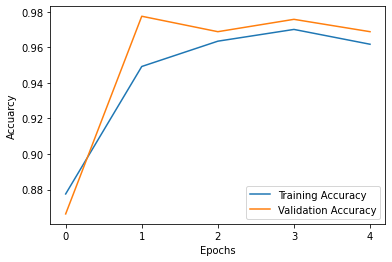

In [11]:
# display the training accuracy and validation accuracy.
tr_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
plt.plot(np.arange(nepochs), tr_acc)
plt.plot(np.arange(nepochs), val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.xticks(np.arange(nepochs))
plt.legend(['Training Accuracy', 'Validation Accuracy'])


In [12]:
# implement a image display helper function
def disp_image(im):
  if (len(im.shape) == 2):
      # Gray scale image
      plt.imshow(im, cmap='gray')    
  else:
      # Color image.  
      im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
      im1 = im1.astype(np.uint8)
      plt.imshow(im1)    
        
  # Remove axis ticks
  plt.xticks([])
  plt.yticks([])

1


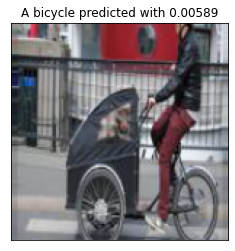

In [14]:
# visualize some error cases
errors = []
true_label = []
error_prob = []
Xts, yts = test_generator.next()
yhat = model.predict(Xts)
yhat_decoded = np.hstack([np.round(yhat, decimals=0), yhat])
for i in range(yts.shape[0]):
  if yhat_decoded[i, 0] != yts[i]:
    errors.append(Xts[i, :, :, :])
    true_label.append(yts[i])
    error_prob.append(yhat_decoded[i, 1])
print(len(true_label))
nerror = 8
nplot2 = np.minimum(nerror, len(errors))
for i in range(nplot2):
  plt.subplot(1, nplot2, i+1)
  disp_image(errors[i])
  if true_label[i] == 0:
    plt.title('A bicycle predicted with ' + str(round(1-error_prob[i], 5)))
  else:
    plt.title('A car predicted with ' + str(round(error_prob[i], 5)))

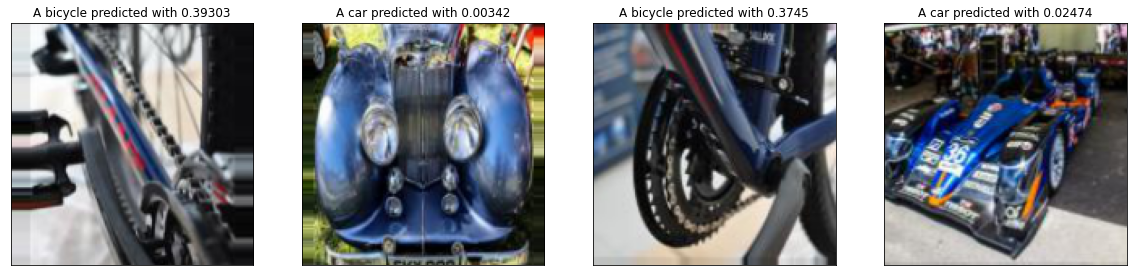